In [29]:
import os
import numpy as np
import matplotlib.pylab as plt
import pickle
import importlib
import shutil

from scipy.interpolate import make_interp_spline

import sys
sys.path.append('/Users/psummers8/Documents/MITgcm/MITgcm/elizaScripts/main_scripts')

import build_domain_funcs as build_domain 
import run_config_funcs as rcf # import helpter functions

writeFiles = True

def write_bin(fname, data):
    print(fname, np.shape(data))
    # setupNotes.write(fname + " " + str(np.shape(data))+'\n')
    if(writeFiles):
        
        data.astype(">f8").tofile(fname)
    else:
        print('Not saving')

## Main run configuration

In [5]:
# set high level run configurations

run_config = {}
run_config['ncpus_xy'] = [1, 1] # cpu distribution in the x and y directions
run_config['run_name'] = 'shelfTest'
run_config['ndays'] = 20 # simulaton time (days)
run_config['test'] = True # if True, run_config['nyrs'] will be shortened to a few time steps

run_config['horiz_res_m'] = 500 # horizontal grid spacing (m)
run_config['Lx_m'] = 25000 # domain size in x (m)
run_config['Ly_m'] = 6000 # domain size in y (m)
# NOTE: the number of grid points in x and y should be multiples of the number of cpus.

run_config['evolve_salt'] = False
run_config['use_GMRedi'] = False # should be set to false for eddy permitting resolutions
run_config['periodic_forcing'] = False # note: the code is not yet set up to handle time-dependent forcing

MITgcm_release = 'MITgcm-checkpoint69a' #Sept 2024 release
#MITgcm_code_dir = os.path.join(group_home_dir, 'shared/mitgcm_releases', MITgcm_release)

# you probably don't need to touch this
run_config['use_MPI'] = False # for multi-processing
run_config['lf'] = '\r\n' # linebreak characters 
run_config['exps_dir'] = os.path.join('/Users/psummers8/Documents/MITgcm/MITgcm/experiments') 
run_config['run_dir'] = os.path.join(run_config['exps_dir'], run_config['run_name'])
run_config

{'ncpus_xy': [1, 1],
 'run_name': 'shelfTest',
 'ndays': 20,
 'test': True,
 'horiz_res_m': 500,
 'Lx_m': 25000,
 'Ly_m': 6000,
 'evolve_salt': False,
 'use_GMRedi': False,
 'periodic_forcing': False,
 'use_MPI': False,
 'lf': '\r\n',
 'exps_dir': '/Users/psummers8/Documents/MITgcm/MITgcm/experiments',
 'run_dir': '/Users/psummers8/Documents/MITgcm/MITgcm/experiments/shelfTest'}

## Domain  and grid parameters

In [6]:
secsInDay = 24*60*60
secsInYear = 365*secsInDay


# set domain size
domain_params = {}
domain_params['Lx'] = run_config['Lx_m'] # domain size in x (m)
domain_params['Ly'] = run_config['Ly_m'] # domain size in y (m)
domain_params['L_sponge'] = 5000 # width of eastern sponge layer (m)
domain_params['H'] = 200 # max domain depth (m)

In [7]:
#---grid parameters ---# 

# NOTE: the only thing you may need to change here is the number of z-grid points)
grid_params = {}

domain_params['Lx']/(run_config['horiz_res_m'])
domain_params['Ly']/(run_config['horiz_res_m'])

grid_params['nSx'] = 1 # num of tiles per processor in x-direction
grid_params['nSy'] = 1 # num of tiles per processor in y-direction
grid_params['nTx'] = 1 # num of threads per processor in x-direction
grid_params['nTy'] = 1 # num of threads per processor in y-direction
grid_params['OLx'] = 3 # num of overlapping x-gridpoints per tile
grid_params['OLy'] = 3 # num of overlapping y-gridpoints per tile
grid_params['Nr'] = 20 # num of z-grid points

grid_params['nPx'] = run_config['ncpus_xy'][0] #num of processors in x-direction
grid_params['nPy'] = run_config['ncpus_xy'][1] #num of processors in x-direction

# grid_params['nSx'] = domain_params['Lx']/(run_config['horiz_res_m']) # num of x points in sub grid
# grid_params['nSy'] = domain_params['Ly']/(run_config['horiz_res_m']) # num of y points in sub grid

# grid_params['Nx'] = grid_params['sNx'] * grid_params['nSx'] * grid_params['nPx']
# grid_params['Ny'] = grid_params['sNy'] * grid_params['nSy'] * grid_params['nPy']

grid_params['Nx'] = domain_params['Lx']/(run_config['horiz_res_m']) # num of x points
grid_params['Ny'] = domain_params['Ly']/(run_config['horiz_res_m']) # num of y points

print("Nx: %s" %grid_params['Nx'])
print("Ny: %s" %grid_params['Ny'])

grid_params['sNx'] = grid_params['Nx']/grid_params['nPx']#num of x-gridpoints per tile
grid_params['sNy'] = grid_params['Ny']/grid_params['nPy'] #num of y-gridpoints per tile

print("sNx: %s" %grid_params['sNx'])
print("sNy: %s" %grid_params['sNy'])

# NOTE: sNx and sNy should be whole numbers/integers. As long we keep the horizontal resolution,
# domain dimesions, and number of cpus to be multiples of five, we should be ok. 

for key, param  in grid_params.items():
    assert param%1==0, "grid parameter needs to be an integer"
    grid_params[key] = int(param)
    
print(grid_params)
#run_config['grid_params'] = grid_params

Nx: 50.0
Ny: 12.0
sNx: 50.0
sNy: 12.0
{'nSx': 1, 'nSy': 1, 'nTx': 1, 'nTy': 1, 'OLx': 3, 'OLy': 3, 'Nr': 20, 'nPx': 1, 'nPy': 1, 'Nx': 50, 'Ny': 12, 'sNx': 50, 'sNy': 12}


In [8]:
# grid_params cont'd
grid_params['usingCartesianGrid'] = True
grid_params['usingSphericalPolarGrid'] = False 

# horizontal grid spacing
grid_params['delX'] = (domain_params['Lx']/grid_params['Nx'])*np.ones(grid_params['Nx'])
grid_params['delY'] = (domain_params['Ly']/grid_params['Ny'])*np.ones(grid_params['Ny'])


# vertical grid spacing 
# spacing increases with depth---can be modified
zidx = np.arange(1, grid_params['Nr']+1)
aa = 10
bb = 10
dz1 = 2*domain_params['H']/grid_params['Nr']/(aa+1)
dz2 = aa*dz1
dz = dz1 + ((dz2-dz1)/2)*(1+np.tanh((zidx-((grid_params['Nr']+1)/2))/aa))
zz1 = np.append([0], np.cumsum(dz))
zz = -(zz1[:-1] + np.diff(zz1)/2) # layer midpoints

grid_params['delZ'] = dz
grid_params['hFacMinDr'] = dz.min()

[18 19]
18
[18 19]
19
T.sgd (20, 12)
S.sgd (20, 12)
U.sgd (20, 12)


Text(0.5, 1.0, 'U')

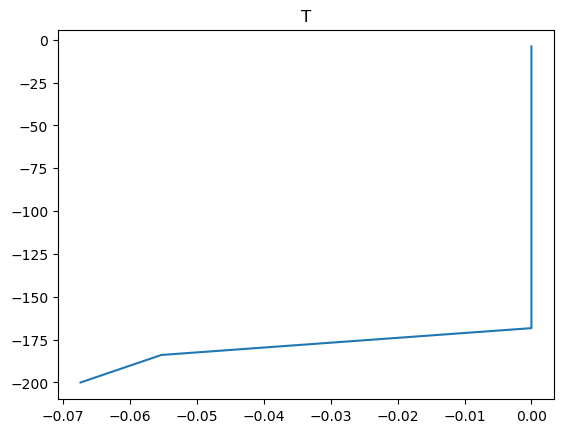

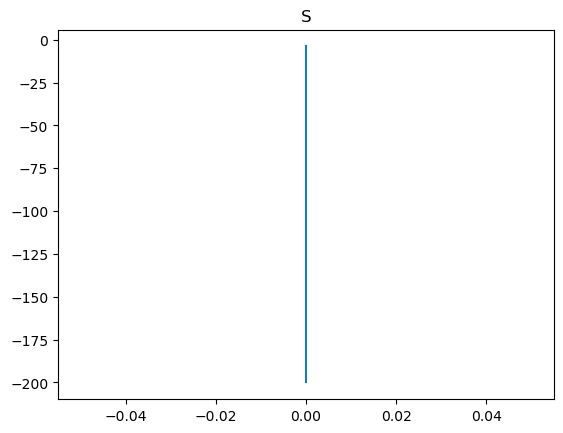

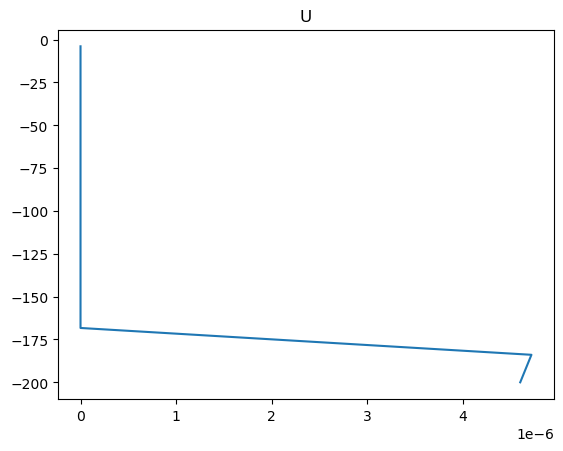

In [30]:
# SGD Boundary
z = -np.cumsum(dz)

sgdd = 20
a0 = -0.0573
c0 = 0.0832
b = -7.53e-4

if sgdd != 0:
    sgdu = np.zeros([grid_params['Nr'],grid_params['Ny']])
    sgdS = np.zeros([grid_params['Nr'],grid_params['Ny']])
    sgdT = np.zeros([grid_params['Nr'],grid_params['Ny']])
    sgdMu = np.zeros([grid_params['Nr'],grid_params['Ny']])
    sgdMtr = np.zeros([grid_params['Nr'],grid_params['Ny']])
    sgd = 0.0123 * 3
    tau = 3600
    sgdi = np.where((z < -domain_params['H'] + sgdd))
    for sgdii in sgdi[0]:
        print(sgdi[0])
        print(sgdii)
        sgdu[sgdii, :] = sgd / run_config['horiz_res_m'] / (dz[sgdii])
        sgdS[sgdii, :] = 0
        sgdT[sgdii, :] = a0 * sgdS[sgdii, 0] + c0 + b * -z[sgdii]
        sgdMu[sgdii, :] = 1
        sgdMtr[sgdii, :] = sgd * tau / (sgdd * run_config['horiz_res_m'] * run_config['horiz_res_m'])

    write_bin("T.sgd", sgdT)
    write_bin("S.sgd", sgdS)
    write_bin("U.sgd", sgdu)
    # write_bin("Mu.sgd", sgdMu)
    # write_bin("Mtr.sgd", sgdMtr)
plt.figure(1)
plt.plot(sgdT[:,0],z)
plt.title('T')
plt.figure(2)
plt.plot(sgdS[:,0],z)
plt.title('S')
plt.figure(3)
plt.plot(sgdu[:,0],z)
plt.title('U')

Text(0.5, 1.0, 'U')

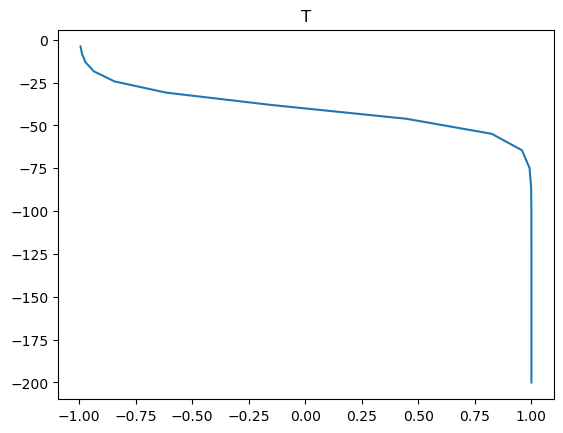

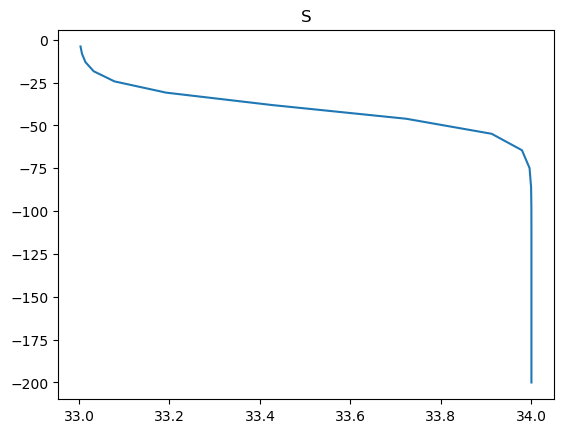

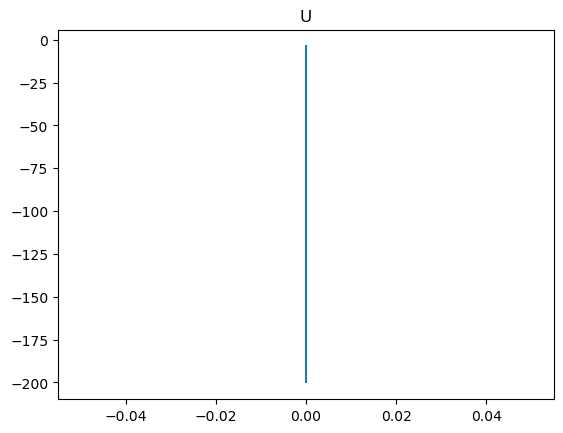

In [21]:
# Temperature profile boundary

gravity = 9.81
sbeta = 8.0e-4
talpha = 0.4e-4
rho0 = 999.8
T0 = 1
S0 = 34

tcd = 40
Tmin = -1
Tmax = 1
Tc = (Tmax + Tmin) / 2
Trange = Tmax - Tmin
T2 = np.zeros([grid_params['Nr'],grid_params['Ny']])
for j in np.arange(0,grid_params['Ny']):
    T2[:,j] = Tc - Trange / 2 * np.tanh(np.pi * (z + tcd) / tcd)
Tconst = np.zeros([grid_params['Nr'],grid_params['Ny']]) + 0.4
T = T2

Sc = 33.5
Srange = -1
S2 = np.zeros([grid_params['Nr'],grid_params['Ny']])
for j in np.arange(0,grid_params['Ny']):
    S2[:,j] = Sc + Srange / 2 * np.tanh(np.pi * (z + tcd) / tcd)
Sconst = np.zeros([grid_params['Nr'],grid_params['Ny']]) + 35

S = S2

Rref = rho0 * (1 - talpha * (T - T0) + sbeta * (S - S0))

t = np.zeros([grid_params['Nr'],grid_params['Ny'],grid_params['Nx']])
s = np.zeros([grid_params['Nr'],grid_params['Ny'],grid_params['Nx']])

for j in np.arange(0,grid_params['Ny']):
    for k in np.arange(0, grid_params['Nr']):
        t[k, j, :] = t[k, j, :] + T[k,j]
        s[k, j, :] = s[k, j, :] + S[k,j]

ubound = np.zeros([grid_params['Nr'],grid_params['Ny']])



# write_bin("T.init", t)
# write_bin("S.init", s)
# write_bin("S.bound", S)
# write_bin("T.bound", T)
# write_bin("U.bound", ubound)

plt.figure(1)
plt.plot(T[:,0],z)
plt.title('T')
plt.figure(2)
plt.plot(S[:,0],z)
plt.title('S')
plt.figure(3)
plt.plot(ubound[:,0],z)
plt.title('U')



## Physical parameters

In [25]:
#---physical params---#

params01 = {} 

# physical constants
g = 9.81 # acc. due to gravity (m/s**2)
Omega = 2*np.pi*366/365/86400 # planetary rotation rate 
Rp = 6400*1000 # planetary radius (m)
lat_min = -70 # latitude at southern boundary (degrees)
#f0 = 2*Omega*np.sin(np.deg2rad(lat_min)) # coriolis param (1/s)
#beta = (2*Omega*np.cos(np.deg2rad(lat_min))/Rp) # beta param


# momentum scheme
params01['vectorInvariantMomentum'] = True

#Note: here and elsewhere, we need to be explicit about floats vs ints. E.g., use 12.0 to represent float and
# 12 for int

 #Tref = 40*0.,
 #Sref = 40*34.,
 #viscAz=0.00001,
 #viscC2smag=2.2,
 #diffKzT=0.00001,
 #diffKhT=30,
 #diffKzS=0.00001,
 #diffKhS=30,
 #no_slip_sides=.FALSE.,
 #no_slip_bottom=.TRUE.,
 #rigidLid=.FALSE.,
 #implicitFreeSurface=.TRUE.,
 #staggerTimeStep=.TRUE.,
readBinaryPrec=64
 #eosType='JMD95Z', 
 #tempAdvScheme=33,
 #saltAdvScheme=33,
f0=0.
beta=0.E-11
 #selectAddFluid=1,


# viscosity parameters
params01['viscAz'] = 0.00001 # Vertical viscosity
params01['viscC2smag'] = 2.2 # ??? viscosity

# advection and time stepping
params01['tempAdvScheme'] = 33 # needs to be int
params01['saltAdvScheme'] = 33 # needs to be int
#params01['tempStepping'] = True
#params01['saltStepping'] = run_config['evolve_salt']
params01['staggerTimeStep'] = True

# diffusivity
params01['diffKzT'] = 0.00001 # Vertical temp diffusion 
params01['diffKhS'] = 30 # ???diffusion
params01['diffKhT'] = 30 # Horizontal temp diffusion

# equation of state
params01['eosType'] = 'JMD95Z'
params01['Tref'] = np.ones(grid_params['Nr'])*0. #ref temp
params01['Sref'] = np.ones(grid_params['Nr'])*34. #ref salt

# boundary conditions
params01['no_slip_sides'] = False
params01['no_slip_bottom'] = True
params01['rigidLid'] = False
params01['implicitFreeSurface'] = True

# physical parameters
params01['f0'] = f0
params01['beta'] = beta
params01['gravity'] = g

# misc
params01['selectAddFluid'] = 1


# AS: Don't allow partial cell height to fall below min grid spacing
#params01['hFacMinDr'] = np.min(dz)

## Check for numericl stability?

## Numeric solvers and I/O controls

In [27]:
# numeric solver parameters 

params02 = {}
params02['cg2dMaxIters'] = 300
params02['cg2dTargetResidual'] = 1e-13
params02['cg3dMaxIters'] = 20
params02['cg3dTargetResidual'] = 1e-8

# time stepping parameters 
params03 = {}
params03['nIter0'] = 0
#params03['endTime'] = 864000.0
deltaT = 100.0
params03['abEps'] = 0.1

#if run_config['testing']:
    
params03['chkptFreq'] = 0.0
params03['pChkptFreq'] = 0.0
params03['taveFreq'] = 0.0
params03['dumpFreq'] = 86400.0
params03['taveFreq'] = 0.0
params03['monitorFreq'] = 86400.0
params03['monitorSelect'] = 2


params03['periodicExternalForcing'] = False
params03['ExternForcingPeriod'] = 100.0
params03['ExternForcingCycle'] = 1000.0 

In [28]:
if run_config['test']:
    nTimeSteps = 10
else:
    nTimeSteps = np.ceil(run_config['ndays']*secsInDay/detlaT)

simTimeAct = nTimeSteps*deltaT

params03['endTime'] = int(params03['nIter0']*deltaT+simTimeAct)
params03['deltaT'] = np.round(deltaT)
grid_params['Nt'] = nTimeSteps

## Create 'data' files

In [29]:
# NOTE: These steps generate the data text files located int the input directory

In [30]:
# gather params for data file 
params04 = {} #<-- using params04 to be consistent with ordering in Andrew's code
params04['usingCartesianGrid'] = grid_params['usingCartesianGrid']
params04['usingSphericalPolarGrid'] = grid_params['usingSphericalPolarGrid']
params04['delX']  = grid_params['delX']
params04['delY'] = grid_params['delY']
params04['delZ'] = dz

In [31]:
# get data fnames param
params05 = {}
params05['bathyFile'] ='bathymetry.bin'
params05['hydrogThetaFile'] = 'tempini.bin'
params05['hydrogSaltFile'] = 'saltini.bin'


In [32]:
data_params = [params01, params02, params03, params04, params05]
rcf.write_data(run_config, data_params, group_name='data', lf=run_config['lf'])

## Make SIZE.h File

In [19]:
# generate size.h file
rcf.createSIZEh(run_config, grid_params)

## Specifiy relaxation of temperature and salinity 

In [20]:
OBCS = {}

## Set boundary conditions

## Specify Diagnostics

In [21]:
# Here we specify variables that should saved (i.e., written to disk) at various time intervals

# adjust output frequency
if run_config['test']:
    run_config['inst_freq'] = 1 # multiples of timestep
    run_config['tavg_freq'] = 5 # multiples of timestep
    
else:
    run_config['inst_freq'] = 1 # multiples of year
    run_config['tavg_freq'] = 5 # multiples of year


#---------specify time averaged fields------#
# NOTE: many more options available see mitgcm docs
diag_fields_avg = ['UVEL', 'VVEL', 'WVEL','UVELTH', 'VVELTH','WVELTH','THETA']

# diag_fields_avg = ['UVEL', 'VVEL', 'WVEL', 'UVELSQ', 'VVELSQ', 'WVELSQ',
#                   'UVELTH', 'VVELTH', 'WVELTH', 'THETA', 'THETASQ',
#                   'PHIHYD', 'LaUH1TH', 'LaVH1TH', 'LaHw1TH','LaHs1TH']

numdiags_avg = len(diag_fields_avg)
diag_phase_avg = 0.0

if run_config['test'] == True:
    diag_freq_inst = -run_config['inst_freq']*deltaT # negative values indicate snapshots at given interval
    diag_freq_avg = run_config['tavg_freq']*deltaT # positive values indicate time average over specified interval
else:
    diag_freq_inst = -run_config['inst_freq']*secsInYear 
    diag_freq_avg = run_config['tavg_freq']*secsInYear
    
    
diag_params01 = {}
diag_params01['diag_mnc'] = False #<---you would need to modify this if you want netcdf output

for ii in range(numdiags_avg):  
    n = ii+1
    diag_params01['fields(1,%s)'%n] = diag_fields_avg[ii]
    diag_params01['fileName(%s)'%n] = diag_fields_avg[ii]
    diag_params01['frequency(%s)'%n] = diag_freq_avg
    diag_params01['timePhase(%s)'%n] = diag_phase_avg

    
#--------specify instanteous fields (i.e. snapshots)--------#
diag_fields_inst = ['UVEL', 'VVEL', 'THETA']
numdiags_inst = len(diag_fields_inst)
diag_phase_inst = 0.0

for ii in range(numdiags_inst):
    n = numdiags_avg+ii+1
    diag_params01['fields(1,%s)'%n] = diag_fields_inst[ii]
    diag_params01['fileName(%s)'%n] = diag_fields_inst[ii] + '_inst'
    diag_params01['frequency(%s)'%n] = diag_freq_inst
    diag_params01['timePhase(%s)'%n] = diag_phase_inst
    
print(diag_params01)
Ndiags = n

{'diag_mnc': False, 'fields(1,1)': 'UVEL', 'fileName(1)': 'UVEL', 'frequency(1)': 500.0, 'timePhase(1)': 0.0, 'fields(1,2)': 'VVEL', 'fileName(2)': 'VVEL', 'frequency(2)': 500.0, 'timePhase(2)': 0.0, 'fields(1,3)': 'WVEL', 'fileName(3)': 'WVEL', 'frequency(3)': 500.0, 'timePhase(3)': 0.0, 'fields(1,4)': 'UVELTH', 'fileName(4)': 'UVELTH', 'frequency(4)': 500.0, 'timePhase(4)': 0.0, 'fields(1,5)': 'VVELTH', 'fileName(5)': 'VVELTH', 'frequency(5)': 500.0, 'timePhase(5)': 0.0, 'fields(1,6)': 'WVELTH', 'fileName(6)': 'WVELTH', 'frequency(6)': 500.0, 'timePhase(6)': 0.0, 'fields(1,7)': 'THETA', 'fileName(7)': 'THETA', 'frequency(7)': 500.0, 'timePhase(7)': 0.0, 'fields(1,8)': 'UVEL', 'fileName(8)': 'UVEL_inst', 'frequency(8)': -100.0, 'timePhase(8)': 0.0, 'fields(1,9)': 'VVEL', 'fileName(9)': 'VVEL_inst', 'frequency(9)': -100.0, 'timePhase(9)': 0.0, 'fields(1,10)': 'THETA', 'fileName(10)': 'THETA_inst', 'frequency(10)': -100.0, 'timePhase(10)': 0.0}


In [22]:
diag_params02={}
diag_params = [diag_params01, diag_params02]
rcf.write_data(run_config, diag_params, group_name='diagnostics')

In [23]:
## create DIAGNOSTICS_SIZE.h
Nlevels = np.max([grid_params['Nr'], Nlayers])
rcf.createDIAGSIZEh(run_config, Ndiags, Nlevels)

NameError: name 'Nlayers' is not defined

## Generate eedata 

In [33]:
# create eedata
rcf.create_eedata(run_config, grid_params['nTx'], grid_params['nTy'])

## Estimate wall clock time

## Next steps

Once you've successfully set up the model experiment, you will need to do the following:

+ Navigate to the build directory and compile the code (i.e., `sh build.sh`). This may take a couple minutes and will generates lots of new files in the build directory. The key file is the `mitgcmuv` executable.



+ Next, go to the results directory and submit the job to Sherlock queue (`sh run.sh`). It is recommended that you do this from a login node. This should generate a unique output_xxx file, which logs error messages for each run. You will get emails when the job is released from the queue and when it is completed. Test runs normally take a few minutes. A successful run will generate dozens of output files, including data files like `THETA_inst_000000.data`. 


To check if the job is running:   `squeue | grep ejdawson`
